In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FL",
    name= "with batch normalization_FedAvg_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "loss": nn.BCELoss(),
    "batch_size": 64,
    "decay":1e-5,
    'dropout': 0.1,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL":1e-5,
    'num_rounds_FL': 10, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    
    }
)

configuration  = dict(wandb.config)


def data_loading_AZURE(data_path, label_path, batch_size, train_ratio=0.8, val_ratio=0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    print((labels==1).sum())
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [3]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # self.conv0 = nn.Conv1d(in_channels=24, out_channels=4, kernel_size=3)
        # self.bn0 = nn.BatchNorm1d(4)
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.relu(self.conv0(x))
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        # x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs, decay, dropout):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            # train_loss = float(l)
            # losses.append(train_loss) # Stores the loss for this batch
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
            # wandb.log({"train_loss": losses,
            #            "train_acc": train_accs,
            #            "Epoch": epoch + 1})
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    print(train_accs)
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Testing accuracy')
    plt.title('accuracies')
    plt.legend()

def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])
AZURE = data_loading_AZURE(data_path='AZURE_data_50.pt', label_path='AZURE_label_50.pt', batch_size= configuration['batch_size'])
# train_loaders = [NASA[0], AZURE[0]]
# val_loaders = [NASA[1], AZURE[1]]
# test_loaders = [NASA[2], AZURE[2]]

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)
tensor(76)
torch.Size([836, 4, 50])
(1520, 4, 50)


In [6]:
azure1 = data_loading_AZURE('AZURE_data_1.pt', 'AZURE_label_1.pt', batch_size=configuration['batch_size_FL'])
azure2 = data_loading_AZURE('AZURE_data_2.pt', 'AZURE_label_2.pt', batch_size=configuration['batch_size_FL'])
azure3 = data_loading_AZURE('AZURE_data_3.pt', 'AZURE_label_3.pt', batch_size=configuration['batch_size_FL'])
azure4 = data_loading_AZURE('AZURE_data_4.pt', 'AZURE_label_4.pt', batch_size=configuration['batch_size_FL'])
train_loaders = [azure1[0], azure2[0], azure3[0], azure4[0]]
val_loaders = [azure1[1], azure2[1], azure3[1], azure4[1]]
test_loaders = [azure1[2], azure2[2], azure3[2], azure4[2]]


tensor(167)
torch.Size([1002, 4, 50])
(1670, 4, 50)
tensor(156)
torch.Size([936, 4, 50])
(1560, 4, 50)
tensor(207)
torch.Size([1242, 4, 50])
(2070, 4, 50)
tensor(169)
torch.Size([1014, 4, 50])
(1690, 4, 50)



Epoch 1/100
Epoch 1: Training accuracy: 51.45985412597656 Testing accuracy: 54.01459884643555.

Epoch 2/100
Epoch 2: Training accuracy: 56.38685989379883 Testing accuracy: 49.63503646850586.

Epoch 3/100
Epoch 3: Training accuracy: 53.10218811035156 Testing accuracy: 45.98540115356445.

Epoch 4/100
Epoch 4: Training accuracy: 52.6459846496582 Testing accuracy: 45.98540115356445.

Epoch 5/100
Epoch 5: Training accuracy: 52.37226104736328 Testing accuracy: 44.52554702758789.

Epoch 6/100
Epoch 6: Training accuracy: 54.01459884643555 Testing accuracy: 46.715328216552734.

Epoch 7/100
Epoch 7: Training accuracy: 56.66058349609375 Testing accuracy: 48.1751823425293.

Epoch 8/100
Epoch 8: Training accuracy: 57.208030700683594 Testing accuracy: 48.90510940551758.

Epoch 9/100
Epoch 9: Training accuracy: 55.83941650390625 Testing accuracy: 47.445255279541016.

Epoch 10/100
Epoch 10: Training accuracy: 60.310218811035156 Testing accuracy: 46.715328216552734.

Epoch 11/100
Epoch 11: Training ac

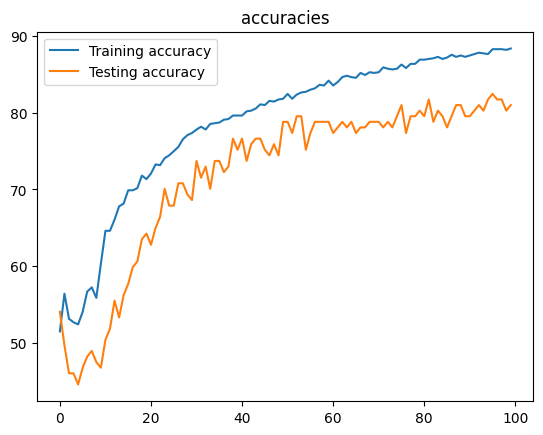

In [7]:
# trainloader = train_loaders[0]
# valloader = val_loaders[0]
# testloader = test_loaders[0]
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = SimpleCNN().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'], configuration['decay'], configuration['dropout'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## transfer learning


Epoch 1/100
Epoch 1: Training accuracy: 59.046051025390625 Testing accuracy: 56.578948974609375.

Epoch 2/100
Epoch 2: Training accuracy: 58.470394134521484 Testing accuracy: 58.55263137817383.

Epoch 3/100
Epoch 3: Training accuracy: 60.279605865478516 Testing accuracy: 58.55263137817383.

Epoch 4/100
Epoch 4: Training accuracy: 62.9934196472168 Testing accuracy: 60.52631759643555.

Epoch 5/100
Epoch 5: Training accuracy: 65.13157653808594 Testing accuracy: 63.157894134521484.

Epoch 6/100
Epoch 6: Training accuracy: 66.85855102539062 Testing accuracy: 65.13157653808594.

Epoch 7/100
Epoch 7: Training accuracy: 67.68092346191406 Testing accuracy: 67.10526275634766.

Epoch 8/100
Epoch 8: Training accuracy: 70.3125 Testing accuracy: 71.0526351928711.

Epoch 9/100
Epoch 9: Training accuracy: 73.10855102539062 Testing accuracy: 73.68421173095703.

Epoch 10/100
Epoch 10: Training accuracy: 74.1776351928711 Testing accuracy: 75.65789794921875.

Epoch 11/100
Epoch 11: Training accuracy: 75.

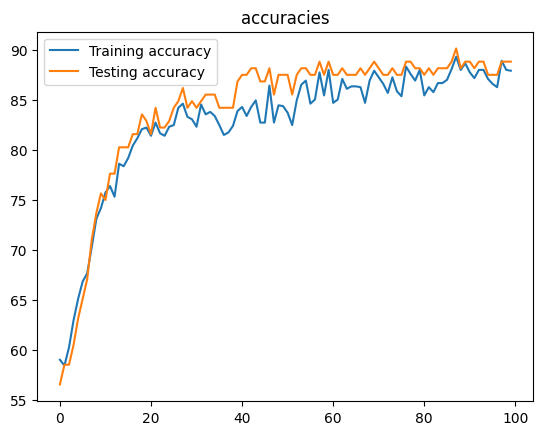

In [8]:
testloader = AZURE[2]
trainloader = AZURE[0]
valloader = AZURE[1]
configuration2={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "loss": nn.BCELoss(),
    "batch_size": 64,
    "decay":1e-5,
    'dropout': 0.1,
    'number of machines': 20
}
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration2, configuration2['epochs'], configuration2['decay'], configuration2['dropout'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

trainloader = train_loaders[1]
valloader = val_loaders[1]
testloader = test_loaders[1]
net = SimpleCNN().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
<!-- # plt.plot(accuracies) -->
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

In [9]:
test(net, testloader, configuration)

(0.14030370116233826, tensor(88.8158, device='cuda:0'))

## Federated Learning

importing azure dataset

In [10]:
for name, val in net.state_dict().items():
    
    print(name)

conv1.weight
conv1.bias
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
conv2.weight
conv2.bias
bn2.weight
bn2.bias
bn2.running_mean
bn2.running_var
bn2.num_batches_tracked
fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [11]:
net.state_dict().items()

odict_items([('conv1.weight', tensor([[[ 0.0487, -0.0024, -0.2049, -0.1575, -0.0701],
         [ 0.2010, -0.0842, -0.0373, -0.1051, -0.0740],
         [-0.2300,  0.0150,  0.0253,  0.0197, -0.0560],
         [ 0.0827,  0.2011,  0.0861,  0.0911,  0.1725]],

        [[-0.0010, -0.1173,  0.2317, -0.0535, -0.1792],
         [-0.0491, -0.0508,  0.0940, -0.1402, -0.2109],
         [ 0.1593, -0.2202, -0.0026,  0.1242,  0.1287],
         [-0.1193, -0.1856,  0.0780,  0.0639,  0.0922]],

        [[ 0.0441, -0.1137,  0.0656,  0.2174, -0.0082],
         [-0.1787,  0.0914, -0.1487, -0.1861,  0.1135],
         [-0.1609, -0.1736,  0.2201,  0.1371,  0.1580],
         [ 0.1021,  0.1721, -0.1592, -0.1784, -0.1132]],

        [[ 0.1605, -0.0336,  0.1418, -0.0750, -0.0734],
         [-0.0580, -0.1317,  0.0382, -0.1248,  0.1549],
         [-0.1364,  0.1933, -0.1147,  0.0258, -0.1994],
         [ 0.2284,  0.0193, -0.0617, -0.1515, -0.0047]],

        [[ 0.0606, -0.0188,  0.1467, -0.0654,  0.0015],
         [

In [12]:
for name, val in net.state_dict().items():
    if ('bn1' not in name and 'bn2' not in name):
        print(name)

'bn1' in 'bn1.bias'

conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


True

In [13]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'], configuration['decay_FL'], configuration['dropout'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = SimpleCNN().to(device)
    trainloader = train_loaders[int(cid)]
    valloader = val_loaders[int(cid)]
    return FlowerClient(net, trainloader, valloader, configuration).to_client()


In [14]:

# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config,):
    net = SimpleCNN().to(device)
    testloader = test_loaders[0]
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'loss': loss,
               "accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(SimpleCNN())
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=1,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=1,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-08-09 16:44:47,951	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 51685525094.0, 'node:192.168.1.146': 1.0, 'memory': 110599558554.0, 'node:__internal_head__': 1.0, 'accelerator_type:G': 1.0, 'GPU': 2.0, 'CPU': 32.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      initial parameters (loss, other metrics): 0.2312850554784139, {'accuracy': tensor(47.3054, device='cuda:0')}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy samp

Server-side evaluation loss 0.2312850554784139 / accuracy 47.305389404296875
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 1/100
(ClientAppActor pid=1431468) Epoch 1: Training accuracy: 50.0 Testing accuracy: 52.694610595703125.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 2/100
(ClientAppActor pid=1431468) Epoch 2: Training accuracy: 50.0 Testing accuracy: 52.694610595703125.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 3/100
(ClientAppActor pid=1431468) Epoch 3: Training accuracy: 50.0 Testing accuracy: 52.694610595703125.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 4/100
(ClientAppActor pid=1431468) Epoch 4: Training accuracy: 50.0 Testing accuracy: 52.694610595703125.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 5/100
(ClientAppActor pid=1431468) Epoch 5: Training accuracy: 65.56886291503906 Testing accuracy: 62.87425231933594.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=143146

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (1, 0.22675412893295288, {'accuracy': tensor(52.6946, device='cuda:0')}, 6.946020019007847)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1431468) Epoch 97: Training accuracy: 85.47904205322266 Testing accuracy: 77.2455062866211.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 98/100
(ClientAppActor pid=1431468) Epoch 98: Training accuracy: 85.92814636230469 Testing accuracy: 77.2455062866211.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 99/100
(ClientAppActor pid=1431468) Epoch 99: Training accuracy: 86.67664337158203 Testing accuracy: 76.6467056274414.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 100/100
(ClientAppActor pid=1431468) Epoch 100: Training accuracy: 85.8532943725586 Testing accuracy: 76.6467056274414.
Server-side evaluation loss 0.22675412893295288 / accuracy 52.694610595703125


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1431468) [tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(65.5689, device='cuda:0'), tensor(74.0269, device='cuda:0'), tensor(74.4761, device='cuda:0'), tensor(75.1497, device='cuda:0'), tensor(75.7485, device='cuda:0'), tensor(77.3204, device='cuda:0'), tensor(77.3204, device='cuda:0'), tensor(79.6407, device='cuda:0'), tensor(80.4641, device='cuda:0'), tensor(80.4641, device='cuda:0'), tensor(81.1377, device='cuda:0'), tensor(81.6617, device='cuda:0'), tensor(81.3623, device='cuda:0'), tensor(81.5868, device='cuda:0'), tensor(82.5599, device='cuda:0'), tensor(82.4102, device='cuda:0'), tensor(81.8862, device='cuda:0'), tensor(82.7844, device='cuda:0'), tensor(83.0838, device='cuda:0'), tensor(83.2335, device='cuda:0'), tensor(81.9611, device='cuda:0'), tensor(83.3832, device='cuda:0'), tensor(83.5329, device='cuda:0'), tensor(83.9072, device='cuda:0'), tensor(84.0569, device='cuda:0'), 

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (2, 0.2290114164352417, {'accuracy': tensor(52.6946, device='cuda:0')}, 11.621892737981398)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1431468) Epoch 97: Training accuracy: 86.90119934082031 Testing accuracy: 78.443115234375.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 98/100
(ClientAppActor pid=1431468) Epoch 98: Training accuracy: 86.07784271240234 Testing accuracy: 77.84431457519531.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 99/100
(ClientAppActor pid=1431468) Epoch 99: Training accuracy: 86.45209503173828 Testing accuracy: 77.84431457519531.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 100/100
(ClientAppActor pid=1431468) Epoch 100: Training accuracy: 87.12574768066406 Testing accuracy: 79.04191589355469.
Server-side evaluation loss 0.2290114164352417 / accuracy 52.694610595703125
(ClientAppActor pid=1431468) [tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(64.9701, device='cuda:0'), tensor(85.0299, device='cuda:0'), tensor(87.2755, device='cuda:0'), ten

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (3, 0.22988752524058023, {'accuracy': tensor(52.6946, device='cuda:0')}, 16.930781749018934)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1431468) Epoch 97: Training accuracy: 86.9760513305664 Testing accuracy: 78.443115234375.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 98/100
(ClientAppActor pid=1431468) Epoch 98: Training accuracy: 87.35029602050781 Testing accuracy: 79.04191589355469.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 99/100
(ClientAppActor pid=1431468) Epoch 99: Training accuracy: 87.12574768066406 Testing accuracy: 78.443115234375.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 100/100
(ClientAppActor pid=1431468) Epoch 100: Training accuracy: 86.90119934082031 Testing accuracy: 79.64071655273438.
(ClientAppActor pid=1431468) [tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(62.4251, device='cuda:0'), tensor(78.4431, device='cuda:0'), tensor(87.1257, device='cuda:0'), tensor(86.6766, device='cuda:0'), tensor(86.9761, device='cuda:0'), tensor(86.9012,

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (4, 0.2318535844484965, {'accuracy': tensor(52.6946, device='cuda:0')}, 21.017843410023488)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1431468) Epoch 97: Training accuracy: 86.00299072265625 Testing accuracy: 78.443115234375.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 98/100
(ClientAppActor pid=1431468) Epoch 98: Training accuracy: 87.12574768066406 Testing accuracy: 78.443115234375.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 99/100
(ClientAppActor pid=1431468) Epoch 99: Training accuracy: 85.7784423828125 Testing accuracy: 75.44910430908203.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 100/100
Server-side evaluation loss 0.2318535844484965 / accuracy 52.694610595703125
(ClientAppActor pid=1431468) Epoch 100: Training accuracy: 86.00299072265625 Testing accuracy: 78.443115234375.
(ClientAppActor pid=1431468) [tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(60.2545, device='cuda:0'), tensor(87.1257, device='cuda:0'), tensor(87.2006, device='cuda:0'), tensor(8

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (5, 0.2312599023183187, {'accuracy': tensor(52.6946, device='cuda:0')}, 25.317782027006615)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1431468) Epoch 96: Training accuracy: 86.75149536132812 Testing accuracy: 79.04191589355469.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 97/100
(ClientAppActor pid=1431468) Epoch 97: Training accuracy: 86.75149536132812 Testing accuracy: 78.443115234375.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 98/100
(ClientAppActor pid=1431468) Epoch 98: Training accuracy: 87.05089569091797 Testing accuracy: 78.443115234375.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 99/100
(ClientAppActor pid=1431468) Epoch 99: Training accuracy: 87.20059967041016 Testing accuracy: 79.04191589355469.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 100/100
(ClientAppActor pid=1431468) Epoch 100: Training accuracy: 87.27545166015625 Testing accuracy: 77.2455062866211.
(ClientAppActor pid=1431468) [tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), 

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (6, 0.23251307010650635, {'accuracy': tensor(52.6946, device='cuda:0')}, 29.65080693899654)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1431468) Epoch 96: Training accuracy: 85.8532943725586 Testing accuracy: 77.84431457519531.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 97/100
(ClientAppActor pid=1431468) Epoch 97: Training accuracy: 86.9760513305664 Testing accuracy: 79.04191589355469.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 98/100
(ClientAppActor pid=1431468) Epoch 98: Training accuracy: 85.2544937133789 Testing accuracy: 76.04790496826172.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 99/100
(ClientAppActor pid=1431468) Epoch 99: Training accuracy: 87.64970397949219 Testing accuracy: 79.04191589355469.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 100/100
Server-side evaluation loss 0.23251307010650635 / accuracy 52.694610595703125
(ClientAppActor pid=1431468) Epoch 100: Training accuracy: 85.7035903930664 Testing accuracy: 75.44910430908203.
(ClientAppActor pid=1431468) [tensor(50., device='cuda:0'), tensor(50.,

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (7, 0.23395119110743204, {'accuracy': tensor(52.6946, device='cuda:0')}, 34.154485953971744)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1431468) Epoch 96: Training accuracy: 85.62874603271484 Testing accuracy: 77.84431457519531.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 97/100
(ClientAppActor pid=1431468) Epoch 97: Training accuracy: 86.9760513305664 Testing accuracy: 79.64071655273438.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 98/100
(ClientAppActor pid=1431468) Epoch 98: Training accuracy: 85.92814636230469 Testing accuracy: 77.84431457519531.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 99/100
(ClientAppActor pid=1431468) Epoch 99: Training accuracy: 84.80538940429688 Testing accuracy: 77.84431457519531.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 100/100
(ClientAppActor pid=1431468) Epoch 100: Training accuracy: 86.00299072265625 Testing accuracy: 77.84431457519531.
Server-side evaluation loss 0.23395119110743204 / accuracy 52.694610595703125
(ClientAppActor pid=1431468) [tensor(50., device='cuda:0'), tensor(5

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (8, 0.23340545097986856, {'accuracy': tensor(52.6946, device='cuda:0')}, 38.472233330016024)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1431468) Epoch 96: Training accuracy: 85.55389404296875 Testing accuracy: 77.84431457519531.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 97/100
(ClientAppActor pid=1431468) Epoch 97: Training accuracy: 86.52694702148438 Testing accuracy: 77.84431457519531.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 98/100
(ClientAppActor pid=1431468) Epoch 98: Training accuracy: 87.27545166015625 Testing accuracy: 78.443115234375.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 99/100
(ClientAppActor pid=1431468) Epoch 99: Training accuracy: 86.82634735107422 Testing accuracy: 79.04191589355469.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 100/100
Server-side evaluation loss 0.23340545097986856 / accuracy 52.694610595703125
(ClientAppActor pid=1431468) Epoch 100: Training accuracy: 87.5 Testing accuracy: 79.04191589355469.
(ClientAppActor pid=1431468) [tensor(50., device='cuda:0'), tensor(50., device='cu

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (9, 0.23440736532211304, {'accuracy': tensor(52.6946, device='cuda:0')}, 42.77946545899613)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1431468) Epoch 96: Training accuracy: 86.52694702148438 Testing accuracy: 77.84431457519531.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 97/100
(ClientAppActor pid=1431468) Epoch 97: Training accuracy: 86.9760513305664 Testing accuracy: 79.64071655273438.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 98/100
(ClientAppActor pid=1431468) Epoch 98: Training accuracy: 86.60179901123047 Testing accuracy: 78.443115234375.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 99/100
(ClientAppActor pid=1431468) Epoch 99: Training accuracy: 87.5748519897461 Testing accuracy: 79.04191589355469.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 100/100
Server-side evaluation loss 0.23440736532211304 / accuracy 52.694610595703125


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1431468) Epoch 100: Training accuracy: 87.35029602050781 Testing accuracy: 79.64071655273438.
(ClientAppActor pid=1431468) [tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(61.3772, device='cuda:0'), tensor(87.2755, device='cuda:0'), tensor(86.9761, device='cuda:0'), tensor(87.2755, device='cuda:0'), tensor(85.9281, device='cuda:0'), tensor(86.9012, device='cuda:0'), tensor(86.1527, device='cuda:0'), tensor(87.1257, device='cuda:0'), tensor(83.9072, device='cuda:0'), tensor(87.0509, device='cuda:0'), tensor(86.2275, device='cuda:0'), tensor(87.3503, device='cuda:0'), tensor(87.4251, device='cuda:0'), tensor(86.4521, device='cuda:0'), tensor(87.6497, device='cuda:0'), tensor(85.4042, device='cuda:0'), tensor(87.3503, device='cuda:0'), tensor(87.1257, device='cuda:0'), tensor(84.7305, device='cuda:0'), tensor(86.5269, device='cuda:0'), tensor(86.7515, device='cuda:0'), tensor(86.6018, device

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (10, 0.23485076427459717, {'accuracy': tensor(52.6946, device='cuda:0')}, 47.37085119500989)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 rounds in 47.40s


(ClientAppActor pid=1431468) Epoch 96: Training accuracy: 87.12574768066406 Testing accuracy: 79.04191589355469.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 97/100
(ClientAppActor pid=1431468) Epoch 97: Training accuracy: 86.75149536132812 Testing accuracy: 78.443115234375.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 98/100
(ClientAppActor pid=1431468) Epoch 98: Training accuracy: 87.4251480102539 Testing accuracy: 79.04191589355469.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 99/100
(ClientAppActor pid=1431468) Epoch 99: Training accuracy: 84.88024139404297 Testing accuracy: 77.2455062866211.
(ClientAppActor pid=1431468) 
(ClientAppActor pid=1431468) Epoch 100/100
Server-side evaluation loss 0.23485076427459717 / accuracy 52.694610595703125


INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.24178157250086466\n'
INFO :      	 '\tround 2: 0.2505686084429423\n'
INFO :      	 '\tround 3: 0.24879944324493408\n'
INFO :      	 '\tround 4: 0.26073338588078815\n'
INFO :      	 '\tround 5: 0.2674928108851115\n'
INFO :      	 '\tround 6: 0.24942527214686075\n'
INFO :      	 '\tround 7: 0.25176016489664715\n'
INFO :      	 '\tround 8: 0.25960326194763184\n'
INFO :      	 '\tround 9: 0.270561158657074\n'
INFO :      	 '\tround 10: 0.2531673113505046\n')History (loss, centralized):
INFO :      	('\tround 0: 0.2312850554784139\n'
INFO :      	 '\tround 1: 0.22675412893295288\n'
INFO :      	 '\tround 2: 0.2290114164352417\n'
INFO :      	 '\tround 3: 0.22988752524058023\n'
INFO :      	 '\tround 4: 0.2318535844484965\n'
INFO :      	 '\tround 5: 0.2312599023183187\n'
INFO :      	 '\tround 6: 0.23251307010650635\n'
INFO :      	 '\tround 7: 0.23395119110743204\n'
INFO :      	 '\tround 8: 0.23340545097986856\n'
INFO : 

(ClientAppActor pid=1431468) Epoch 100: Training accuracy: 86.22754669189453 Testing accuracy: 77.84431457519531.
(ClientAppActor pid=1431468) [tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(50., device='cuda:0'), tensor(59.7305, device='cuda:0'), tensor(87.5000, device='cuda:0'), tensor(86.4521, device='cuda:0'), tensor(86.6018, device='cuda:0'), tensor(84.5060, device='cuda:0'), tensor(86.6766, device='cuda:0'), tensor(87.2006, device='cuda:0'), tensor(87.4251, device='cuda:0'), tensor(87.5000, device='cuda:0'), tensor(85.5539, device='cuda:0'), tensor(87.5000, device='cuda:0'), tensor(87.1257, device='cuda:0'), tensor(85.8533, device='cuda:0'), tensor(86.0778, device='cuda:0'), tensor(87.5000, device='cuda:0'), tensor(86.3024, device='cuda:0'), tensor(87.5000, device='cuda:0'), tensor(87.0509, device='cuda:0'), tensor(86.9012, device='cuda:0'), tensor(86.3024, device='cuda:0'), tensor(87.6497, device='cuda:0'), tensor(87.5749, device

In [15]:
fl_acc

[tensor(47.3054, device='cuda:0'),
 tensor(52.6946, device='cuda:0'),
 tensor(52.6946, device='cuda:0'),
 tensor(52.6946, device='cuda:0'),
 tensor(52.6946, device='cuda:0'),
 tensor(52.6946, device='cuda:0'),
 tensor(52.6946, device='cuda:0'),
 tensor(52.6946, device='cuda:0'),
 tensor(52.6946, device='cuda:0'),
 tensor(52.6946, device='cuda:0'),
 tensor(52.6946, device='cuda:0')]

# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
def weighted_average(metrics) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=2,
    min_available_clients=2,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=50),
    strategy=strategy,
    # client_resources=client_resources,
)

# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=fl.server.strategy.FedAvg(),
    client_resources=client_resources
)